In [2]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [3]:
SOFT_CONN = True

input_graph = torch.load("data/tree_30.pt")

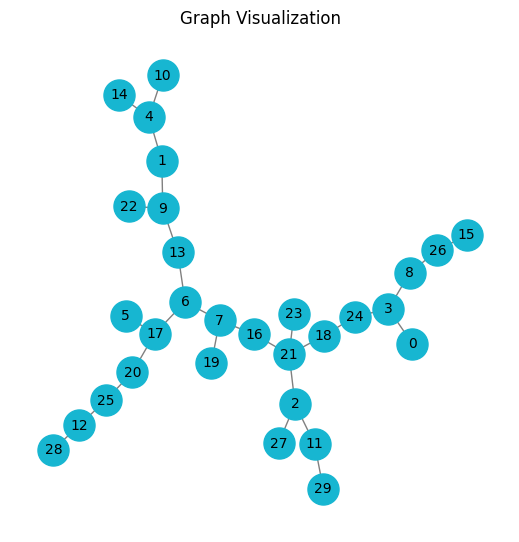

In [189]:
plot_graph(input_graph, labels=True)

## Parametri comuni

In [4]:
alpha = 0.001
niter = 200000
min_change = 0.05
update_steps = 3

niter_sampling = 100000

## MH sampling con i 5 osservabili

In [26]:
class MySamplerFiveStats(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)



sampler_five_stats = MySamplerFiveStats(backend="cuda")
obs_five_stats = sampler_five_stats.observables(input_graph)

params_five_stats, _ = sampler_five_stats.param_run(graph=input_graph,
                      observables=obs_five_stats,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [03:12<00:00, 1038.29it/s]

number of accepted steps is:  37242
number of rejected samples:  162758
number of effective updates is:  12414


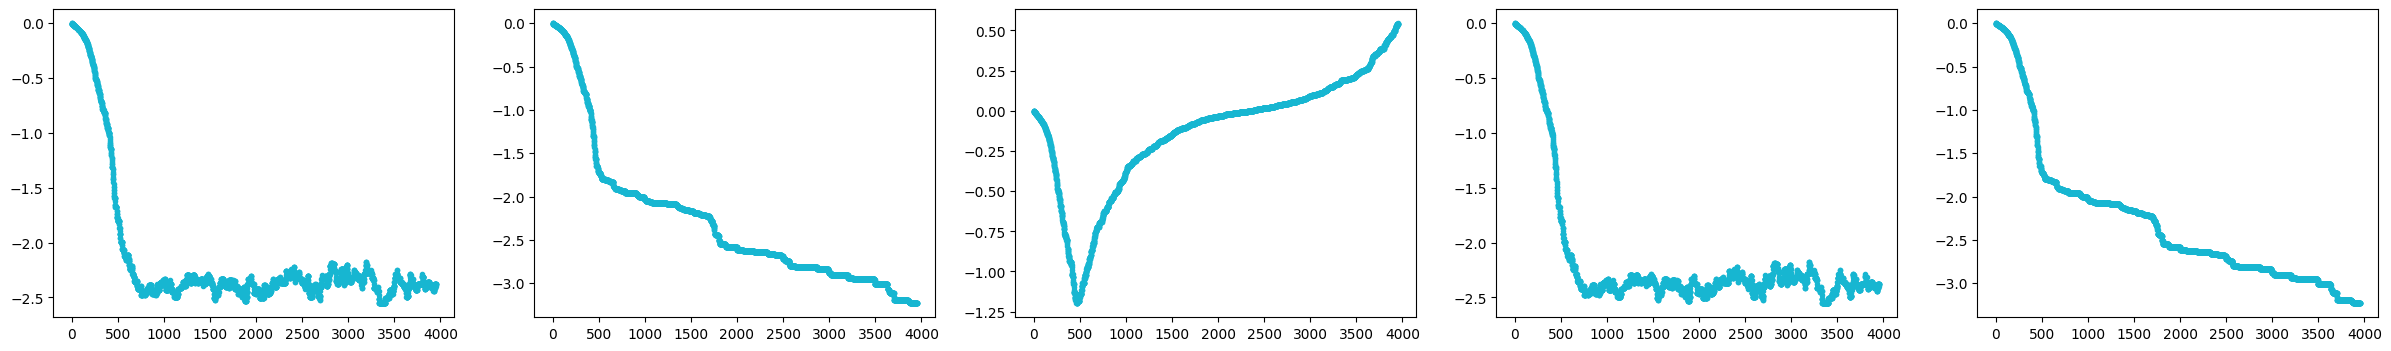

In [27]:
plot_params_iterations(params_five_stats)

In [28]:
params_for_estimates = torch.stack(params_five_stats[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables_five_stats, graphs_five_stats = sampler_five_stats.sample_run(graph=input_graph,
                      observables=obs_five_stats,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 200000/200000 [02:46<00:00, 1203.06it/s]

number of accepted steps is:  26065
number of rejected samples:  173935
Mean obs:  tensor([2.8189e+01, 2.4982e-02, 6.5144e-04, 1.8793e+00, 7.3957e-04],
       dtype=torch.float64)


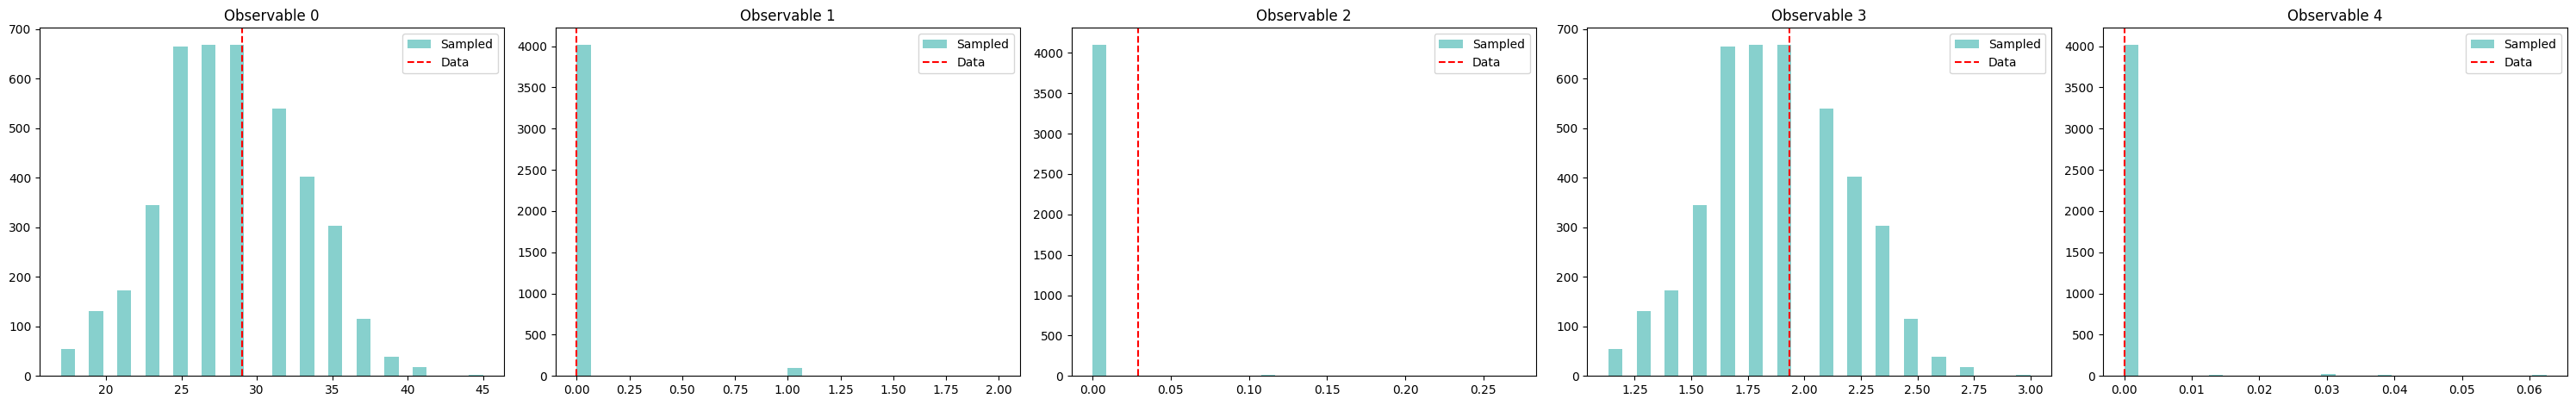

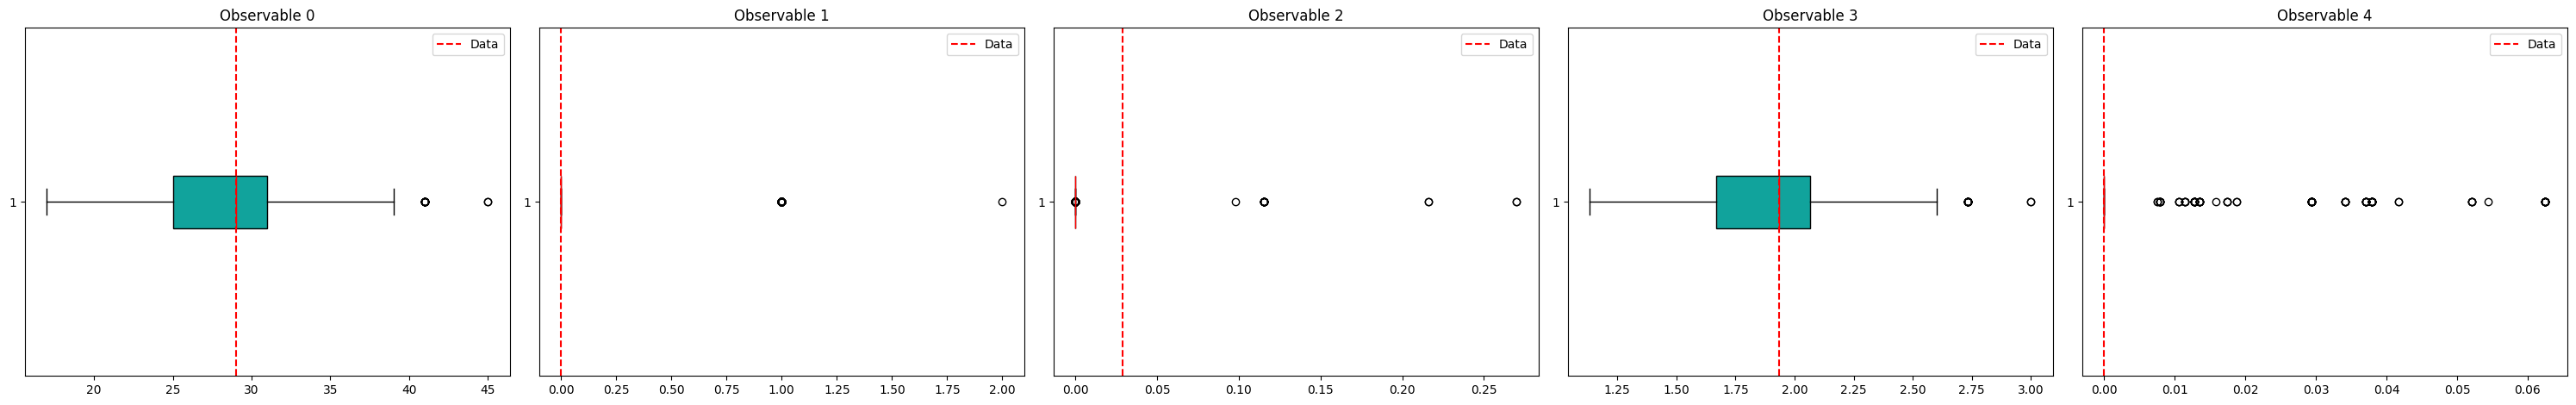

In [30]:
hist_obs_samples(observables_five_stats, obs_five_stats)
boxplot_obs_samples(observables_five_stats, obs_five_stats)

In [31]:
trees_count = 0
for g in graphs_five_stats:
    nx_graph = nx.from_numpy_array(graphs_five_stats[0].numpy())
    connected_components = nx.connected_components(nx_graph)
    maj_graph = nx.subgraph(nx_graph, max(connected_components))

    if nx.is_tree(maj_graph): trees_count+=1

trees_count

0

Nonostante i valori dei parametri fossero molto vicini, nessuna delle parti connesse maggiori è un albero

---

## Gibbs Sampling con 5 osservabili

In [41]:
class MyGWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


GWGsampler = MyGWGSampler(backend="cuda")
obsGWG = GWGsampler.observables(input_graph)

paramsGWG, _ = GWGsampler.param_run(graph=input_graph,
                      observables=obsGWG,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [07:37<00:00, 437.57it/s]

number of accepted steps is:  53739
number of rejected samples:  146261
number of effective updates is:  17913


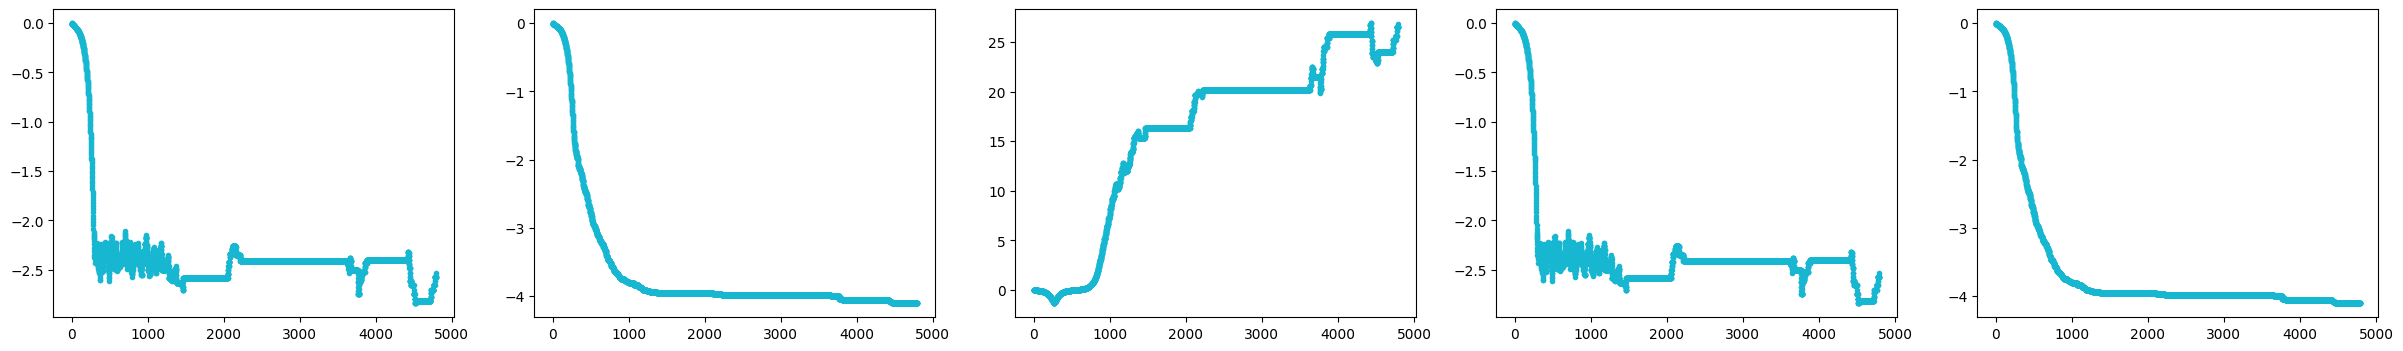

In [42]:
plot_params_iterations(paramsGWG)

In [43]:
params_for_estimates2 = torch.stack(paramsGWG[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observablesGWG, graphsGWG = GWGsampler.sample_run(graph=input_graph,
                      observables=obsGWG,
                      params=params_for_estimates2,
                      niter=100000,
                      save_every=50)

100%|██████████| 100000/100000 [02:39<00:00, 628.28it/s]

number of accepted steps is:  2227
number of rejected samples:  97773
Mean obs:  tensor([2.4356e+01, 1.5601e-03, 7.5898e-03, 1.6237e+00, 2.8890e-05],
       dtype=torch.float64)


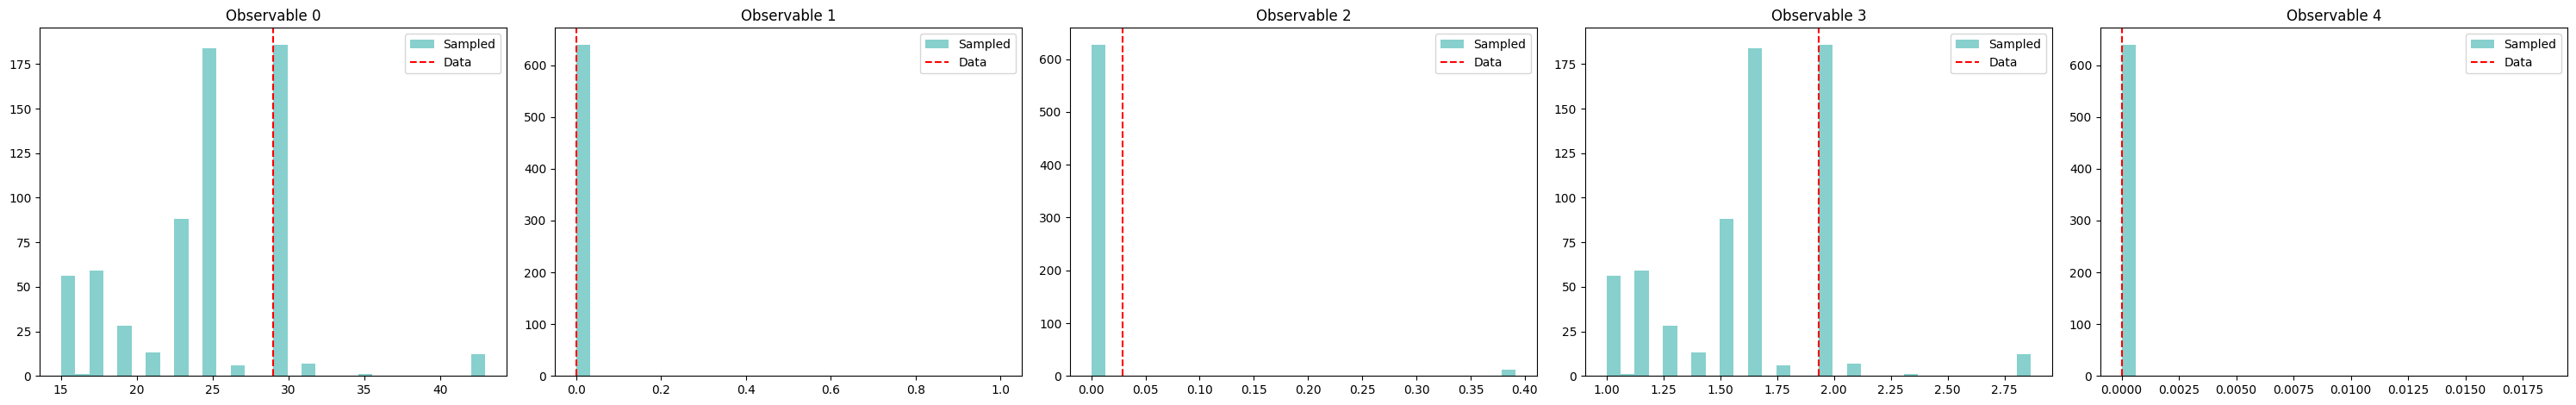

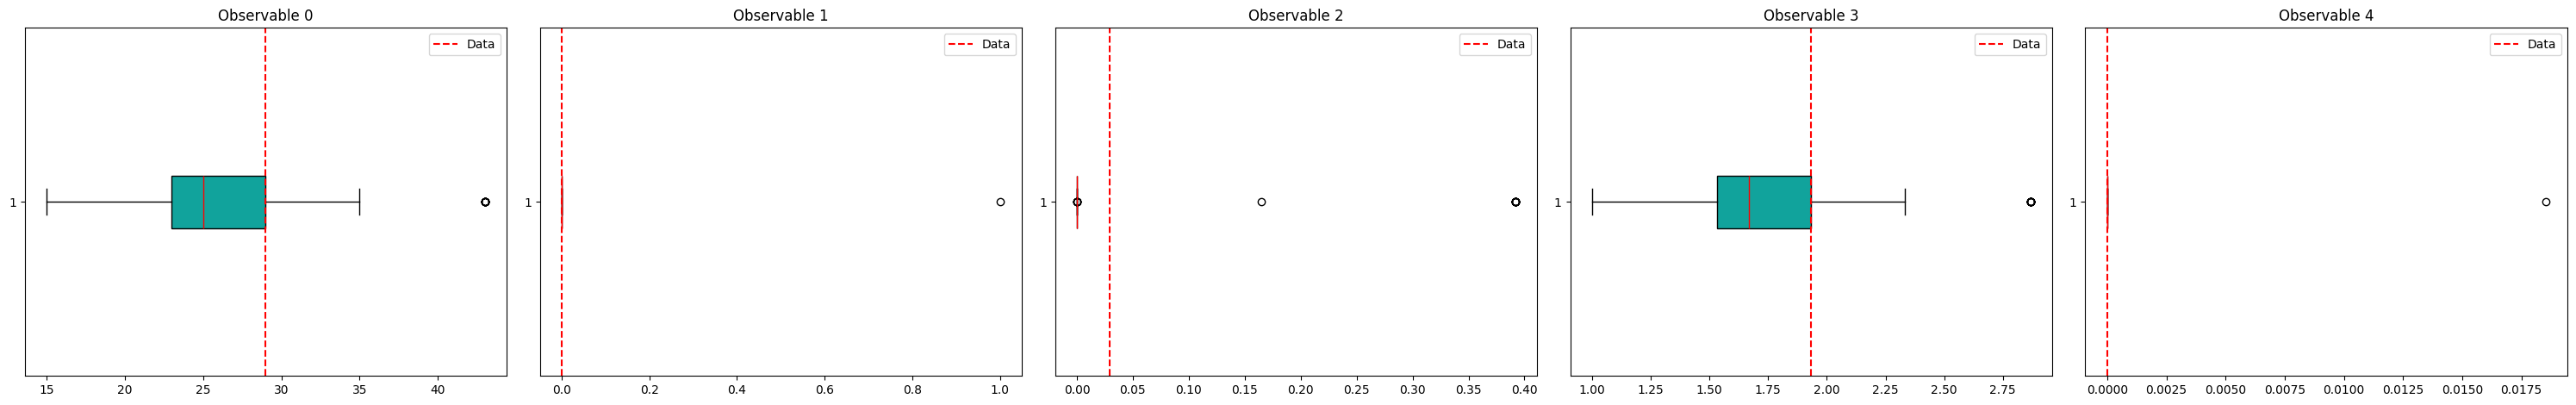

In [44]:
hist_obs_samples(observablesGWG, obsGWG)
boxplot_obs_samples(observablesGWG, obsGWG)

In [46]:
c = 0
for g in graphsGWG:
    nx_graph = nx.from_numpy_array(graphsGWG[0].numpy())
    connected_components = nx.connected_components(nx_graph)
    maj_graph = nx.subgraph(nx_graph, max(connected_components))

    if nx.is_tree(maj_graph): c+=1
        
c

0

Sempre nessun albero

In [1]:
print(mean_difference(sampler_five_stats, input_graph, graphs_five_stats))
print(mean_difference(GWGsampler, input_graph, graphsGWG))

NameError: name 'mean_difference' is not defined

---

In [ ]:
def get_stats_from_sampler(input_graph, sampler, n_iter_training, n_iter_sampling, n_processes, init_betas, alpha=0.001, min_change=0.05, update_steps=3):
    
    input_obs = sampler.observables(input_graph)

    mean_values = []

    for i in range(n_processes):
        #train the model
        params, _ = sampler.param_run(graph=input_graph,
                            observables=input_obs,
                            params=init_betas,
                            niter=n_iter_training,
                            params_update_every=update_steps,
                            save_every=50,
                            save_params=True,
                            alpha=alpha,                      
                            min_change=min_change)
        
        params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)

        #sample
        observables, _ = sampler.sample_run(graph=input_graph,
                            observables=input_obs,
                            params=params_for_estimates,
                            niter=n_iter_sampling,
                            save_every=50,
                            burn_in = 0.01)
        
        mean_values.append(torch.stack(observables).mean(axis=0))

    #return mean and variance of the means
    return torch.stack(mean_values).mean(axis=0), torch.stack(mean_values).std(axis=0), torch.stack(mean_values)


In [ ]:
class MyGWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        return(torch.stack([edges, triangles, ac, avg_clustering]))


betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_for_runs = MyGWGSampler(backend="cuda")
tmp = sampler_for_runs.observables(input_graph)
mean, std, all_means = get_stats_from_sampler(input_graph = input_graph, sampler = sampler_for_runs, n_iter_training = 100000, n_iter_sampling = 100000, n_processes= 30, init_betas= betas)


CUDA backend not available falling back to cpu


100%|██████████| 100000/100000 [03:25<00:00, 487.06it/s]


number of accepted steps is:  52289
number of rejected samples:  47711
number of effective updates is:  17429


100%|██████████| 100000/100000 [02:20<00:00, 709.29it/s]


number of accepted steps is:  7422
number of rejected samples:  92578
Mean obs:  tensor([2.7806e+01, 1.8067e-03, 4.1994e-02, 4.9899e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:25<00:00, 487.76it/s]


number of accepted steps is:  51267
number of rejected samples:  48733
number of effective updates is:  17089


100%|██████████| 100000/100000 [02:05<00:00, 794.96it/s]


number of accepted steps is:  5083
number of rejected samples:  94917
Mean obs:  tensor([2.7217e+01, 0.0000e+00, 1.4165e-02, 0.0000e+00], dtype=torch.float64)


100%|██████████| 100000/100000 [02:33<00:00, 652.63it/s]


number of accepted steps is:  50739
number of rejected samples:  49261
number of effective updates is:  16913


100%|██████████| 100000/100000 [01:43<00:00, 966.91it/s]


number of accepted steps is:  6717
number of rejected samples:  93283
Mean obs:  tensor([2.5587e+01, 5.8480e-03, 4.0455e-03, 3.7758e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [02:33<00:00, 650.21it/s]


number of accepted steps is:  51054
number of rejected samples:  48946
number of effective updates is:  17018


100%|██████████| 100000/100000 [01:58<00:00, 842.98it/s]


number of accepted steps is:  9737
number of rejected samples:  90263
Mean obs:  tensor([2.9251e+01, 2.5907e-03, 3.8317e-02, 5.2113e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:35<00:00, 463.79it/s]


number of accepted steps is:  51624
number of rejected samples:  48376
number of effective updates is:  17208


100%|██████████| 100000/100000 [02:14<00:00, 743.52it/s]


number of accepted steps is:  8910
number of rejected samples:  91090
Mean obs:  tensor([2.9325e+01, 1.4539e-02, 3.6079e-02, 5.5575e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:13<00:00, 517.41it/s]


number of accepted steps is:  51673
number of rejected samples:  48327
number of effective updates is:  17224


100%|██████████| 100000/100000 [02:15<00:00, 740.74it/s]


number of accepted steps is:  13435
number of rejected samples:  86565
Mean obs:  tensor([3.7439e+01, 1.7232e-02, 2.0299e-01, 3.9861e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:03<00:00, 545.19it/s]


number of accepted steps is:  50445
number of rejected samples:  49555
number of effective updates is:  16815


100%|██████████| 100000/100000 [02:16<00:00, 733.11it/s]


number of accepted steps is:  5446
number of rejected samples:  94554
Mean obs:  tensor([2.6872e+01, 4.1347e-03, 2.0630e-02, 1.5370e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:06<00:00, 535.79it/s]


number of accepted steps is:  51501
number of rejected samples:  48499
number of effective updates is:  17167


100%|██████████| 100000/100000 [02:07<00:00, 784.48it/s]


number of accepted steps is:  5196
number of rejected samples:  94804
Mean obs:  tensor([2.5340e+01, 2.3516e-03, 2.8057e-03, 2.8485e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:04<00:00, 543.48it/s]


number of accepted steps is:  51540
number of rejected samples:  48460
number of effective updates is:  17180


100%|██████████| 100000/100000 [02:00<00:00, 827.29it/s]


number of accepted steps is:  3607
number of rejected samples:  96393
Mean obs:  tensor([2.6628e+01, 9.8814e-04, 5.0071e-03, 2.2282e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:10<00:00, 526.18it/s]


number of accepted steps is:  52568
number of rejected samples:  47432
number of effective updates is:  17522


100%|██████████| 100000/100000 [02:11<00:00, 762.36it/s]


number of accepted steps is:  8269
number of rejected samples:  91731
Mean obs:  tensor([3.4398e+01, 1.9231e-02, 1.6675e-01, 5.8266e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:13<00:00, 517.30it/s]


number of accepted steps is:  52364
number of rejected samples:  47636
number of effective updates is:  17454


100%|██████████| 100000/100000 [02:12<00:00, 755.30it/s]


number of accepted steps is:  9510
number of rejected samples:  90490
Mean obs:  tensor([3.4771e+01, 2.0998e-02, 1.2129e-01, 3.5481e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:10<00:00, 524.31it/s]


number of accepted steps is:  51690
number of rejected samples:  48310
number of effective updates is:  17230


100%|██████████| 100000/100000 [02:09<00:00, 770.62it/s]


number of accepted steps is:  6009
number of rejected samples:  93991
Mean obs:  tensor([2.8230e+01, 8.2850e-04, 1.8465e-02, 1.0228e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:13<00:00, 516.86it/s]


number of accepted steps is:  51995
number of rejected samples:  48005
number of effective updates is:  17331


100%|██████████| 100000/100000 [02:09<00:00, 773.58it/s]


number of accepted steps is:  6740
number of rejected samples:  93260
Mean obs:  tensor([2.5929e+01, 0.0000e+00, 2.4548e-02, 0.0000e+00], dtype=torch.float64)


100%|██████████| 100000/100000 [03:12<00:00, 518.38it/s]


number of accepted steps is:  52502
number of rejected samples:  47498
number of effective updates is:  17500


100%|██████████| 100000/100000 [02:09<00:00, 772.13it/s]


number of accepted steps is:  6150
number of rejected samples:  93850
Mean obs:  tensor([2.4484e+01, 1.9718e-02, 2.2245e-02, 2.5151e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:11<00:00, 523.08it/s]


number of accepted steps is:  50781
number of rejected samples:  49219
number of effective updates is:  16927


100%|██████████| 100000/100000 [02:07<00:00, 784.87it/s]


number of accepted steps is:  5017
number of rejected samples:  94983
Mean obs:  tensor([2.4883e+01, 4.3621e-03, 1.1077e-02, 1.0327e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:12<00:00, 520.72it/s]


number of accepted steps is:  50828
number of rejected samples:  49172
number of effective updates is:  16942


100%|██████████| 100000/100000 [02:07<00:00, 786.58it/s]


number of accepted steps is:  4549
number of rejected samples:  95451
Mean obs:  tensor([2.3607e+01, 2.1053e-02, 8.1461e-03, 5.3571e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:10<00:00, 525.15it/s]


number of accepted steps is:  51081
number of rejected samples:  48919
number of effective updates is:  17027


100%|██████████| 100000/100000 [02:15<00:00, 735.83it/s]


number of accepted steps is:  12702
number of rejected samples:  87298
Mean obs:  tensor([3.6865e+01, 1.8519e-02, 1.8305e-01, 2.1005e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:14<00:00, 513.20it/s]


number of accepted steps is:  52287
number of rejected samples:  47713
number of effective updates is:  17429


100%|██████████| 100000/100000 [02:11<00:00, 762.96it/s]


number of accepted steps is:  11238
number of rejected samples:  88762
Mean obs:  tensor([3.2389e+01, 1.2306e-02, 1.0110e-01, 1.9949e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:11<00:00, 522.19it/s]


number of accepted steps is:  51226
number of rejected samples:  48774
number of effective updates is:  17075


100%|██████████| 100000/100000 [02:11<00:00, 762.08it/s]


number of accepted steps is:  7491
number of rejected samples:  92509
Mean obs:  tensor([2.4382e+01, 6.7768e-03, 4.5171e-03, 3.5688e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:12<00:00, 520.09it/s]


number of accepted steps is:  51724
number of rejected samples:  48276
number of effective updates is:  17241


100%|██████████| 100000/100000 [02:15<00:00, 740.58it/s]


number of accepted steps is:  14402
number of rejected samples:  85598
Mean obs:  tensor([3.4937e+01, 1.1208e-01, 1.4435e-01, 1.6501e-03], dtype=torch.float64)


100%|██████████| 100000/100000 [03:14<00:00, 513.18it/s]


number of accepted steps is:  51774
number of rejected samples:  48226
number of effective updates is:  17258


100%|██████████| 100000/100000 [02:13<00:00, 748.62it/s]


number of accepted steps is:  10575
number of rejected samples:  89425
Mean obs:  tensor([2.9394e+01, 1.1510e-02, 4.1618e-02, 1.7104e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:12<00:00, 520.79it/s]


number of accepted steps is:  52327
number of rejected samples:  47673
number of effective updates is:  17442


100%|██████████| 100000/100000 [02:16<00:00, 732.42it/s]


number of accepted steps is:  5522
number of rejected samples:  94478
Mean obs:  tensor([2.3288e+01, 9.1575e-04, 1.4812e-02, 9.3923e-06], dtype=torch.float64)


100%|██████████| 100000/100000 [03:09<00:00, 527.62it/s]


number of accepted steps is:  51124
number of rejected samples:  48876
number of effective updates is:  17041


100%|██████████| 100000/100000 [02:11<00:00, 758.90it/s]


number of accepted steps is:  6148
number of rejected samples:  93852
Mean obs:  tensor([2.2409e+01, 1.6856e-03, 4.3397e-03, 3.9404e-05], dtype=torch.float64)


100%|██████████| 100000/100000 [03:14<00:00, 513.37it/s]


number of accepted steps is:  51501
number of rejected samples:  48499
number of effective updates is:  17167


100%|██████████| 100000/100000 [02:14<00:00, 743.55it/s]


number of accepted steps is:  9749
number of rejected samples:  90251
Mean obs:  tensor([4.4520e+01, 1.0316e-02, 4.1289e-01, 1.3583e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:13<00:00, 517.23it/s]


number of accepted steps is:  51935
number of rejected samples:  48065
number of effective updates is:  17311


100%|██████████| 100000/100000 [02:07<00:00, 782.46it/s]


number of accepted steps is:  5527
number of rejected samples:  94473
Mean obs:  tensor([ 1.8344e+01,  2.6469e-03, -3.3913e-16,  1.5808e-04],
       dtype=torch.float64)


100%|██████████| 100000/100000 [03:11<00:00, 521.91it/s]


number of accepted steps is:  52729
number of rejected samples:  47271
number of effective updates is:  17576


100%|██████████| 100000/100000 [02:09<00:00, 774.86it/s]


number of accepted steps is:  4950
number of rejected samples:  95050
Mean obs:  tensor([2.2434e+01, 4.6680e-03, 3.5429e-04, 1.2967e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:09<00:00, 528.93it/s]


number of accepted steps is:  50913
number of rejected samples:  49087
number of effective updates is:  16971


100%|██████████| 100000/100000 [02:05<00:00, 797.92it/s]


number of accepted steps is:  4900
number of rejected samples:  95100
Mean obs:  tensor([2.4542e+01, 1.0266e-02, 1.5905e-03, 4.0874e-04], dtype=torch.float64)


100%|██████████| 100000/100000 [03:08<00:00, 530.94it/s]


number of accepted steps is:  51512
number of rejected samples:  48488
number of effective updates is:  17170


100%|██████████| 100000/100000 [02:15<00:00, 737.78it/s]


number of accepted steps is:  4272
number of rejected samples:  95728
Mean obs:  tensor([2.0852e+01, 0.0000e+00, 2.9462e-04, 0.0000e+00], dtype=torch.float64)


100%|██████████| 100000/100000 [03:13<00:00, 516.71it/s]


number of accepted steps is:  52726
number of rejected samples:  47274
number of effective updates is:  17575


100%|██████████| 100000/100000 [02:08<00:00, 779.42it/s]


number of accepted steps is:  6061
number of rejected samples:  93939
Mean obs:  tensor([2.5855e+01, 1.1747e-01, 4.6325e-03, 3.8595e-03], dtype=torch.float64)


100%|██████████| 100000/100000 [03:10<00:00, 526.21it/s]


number of accepted steps is:  51153
number of rejected samples:  48847
number of effective updates is:  17051


100%|██████████| 100000/100000 [02:13<00:00, 748.61it/s]

number of accepted steps is:  13585
number of rejected samples:  86415
Mean obs:  tensor([3.8570e+01, 3.2593e-02, 2.2528e-01, 3.3988e-04], dtype=torch.float64)


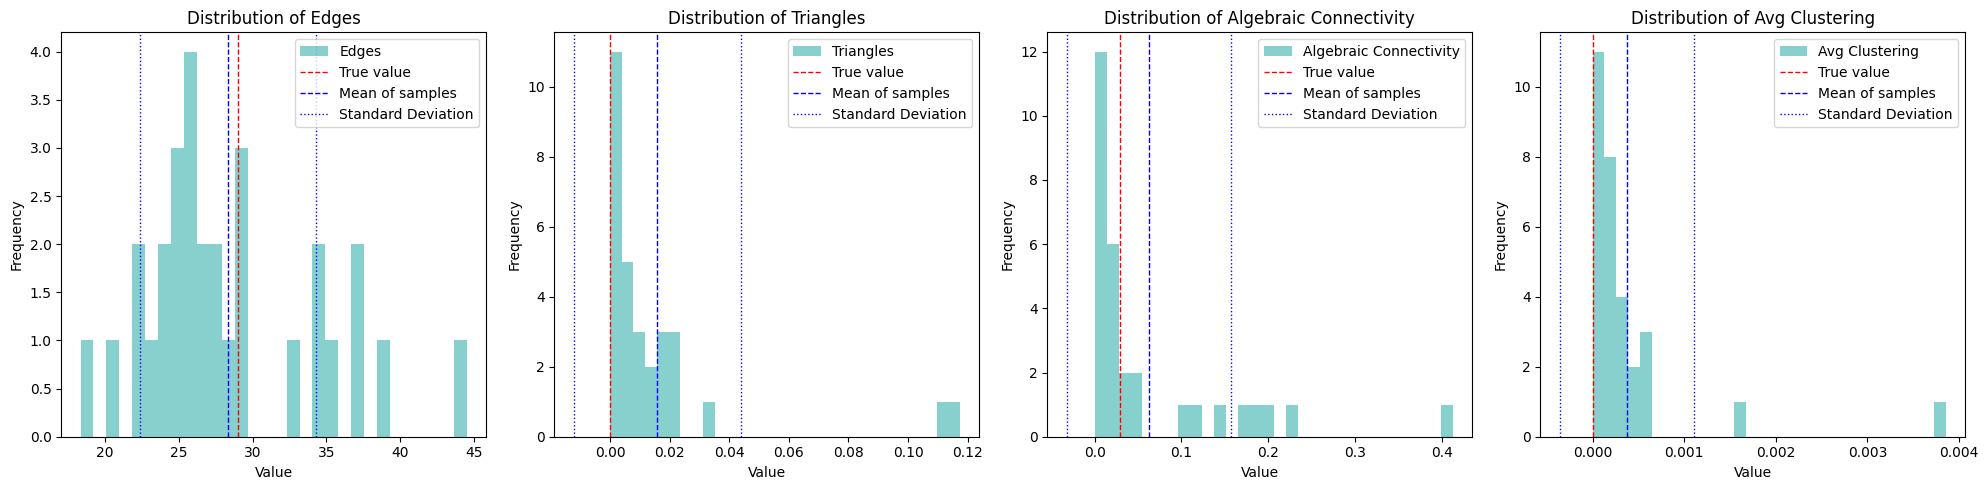

In [191]:
tmp = sampler_for_runs.observables(input_graph)
plot_stats_on_samples(true_vals=tmp, mean_samplers=all_means, std_samplers=std, observables_labels=["Edges", "Triangles", "Algebraic Connectivity", "Avg Clustering"])

In [197]:
mean, std

(tensor([2.8352e+01, 1.5915e-02, 6.2580e-02, 3.7149e-04], dtype=torch.float64),
 tensor([5.9563e+00, 2.8151e-02, 9.4847e-02, 7.3180e-04], dtype=torch.float64))